In [1]:
import os
if not os.path.exists('pytorch_stylegan_encoder'):
    !git clone https://github.com/jacobhallberg/pytorch_stylegan_encoder.git
    %cd pytorch_stylegan_encoder
    !git clone https://github.com/genforce/interfacegan.git
    !git submodule update --init --recursive
    !wget -q https://github.com/jacobhallberg/pytorch_stylegan_encoder/releases/download/v1.0/trained_models.zip
    !unzip -q trained_models.zip
    !rm trained_models.zip
    !pip install -qU torch_snippets
    !mv trained_models/stylegan_ffhq.pth interfacegan/models/pretrain
else:
    %cd pytorch_stylegan_encoder

from torch_snippets import *

Cloning into 'pytorch_stylegan_encoder'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 361 (delta 0), reused 0 (delta 0), pack-reused 358
Receiving objects: 100% (361/361), 56.89 MiB | 37.58 MiB/s, done.
Resolving deltas: 100% (185/185), done.
/content/pytorch_stylegan_encoder
Cloning into 'interfacegan'...
remote: Enumerating objects: 613, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 613 (delta 94), reused 92 (delta 92), pack-reused 489
Receiving objects: 100% (613/613), 13.72 MiB | 30.46 MiB/s, done.
Resolving deltas: 100% (204/204), done.
Submodule 'InterFaceGAN' (git://github.com/ShenYujun/InterFaceGAN.git) registered for path 'InterFaceGAN'
Cloning into '/content/pytorch_stylegan_encoder/InterFaceGAN'...
fatal: unable to connect to github.com:
github.com[0: 140.82.114.4]: errno=Connection timed out

fatal: clon

In [2]:
from interfacegan.models.stylegan_generator import StyleGANGenerator
from models.latent_optimizer import PostSynthesisProcessing

synthesizer = StyleGANGenerator("stylegan_ffhq").model.synthesis
mapper = StyleGANGenerator("stylegan_ffhq").model.mapping
trunc = StyleGANGenerator("stylegan_ffhq").model.truncation

In [3]:
post_processing = PostSynthesisProcessing()
post_process = lambda image: post_processing(image).detach().cpu().numpy().astype(np.uint8)[0]

def latent2image(latent):
    img = post_process(synthesizer(latent))
    img = img.transpose(1,2,0)
    return img

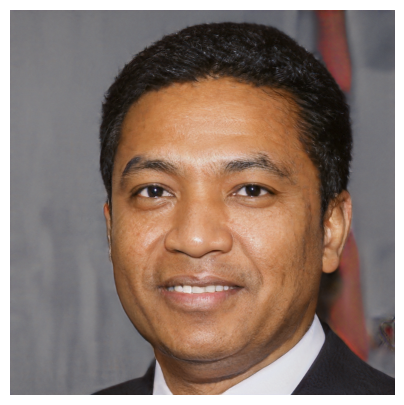

In [4]:
rand_latents = torch.randn(1,512).cuda()
show(latent2image(trunc(mapper(rand_latents))), sz=5)

In [5]:
!wget -q https://www.dropbox.com/s/lpw10qawsc5ipbn/MyImage.JPG -O MyImage.jpg
!git clone https://github.com/sizhky/stylegan-encoder.git
!mkdir -p stylegan-encoder/raw_images
!mkdir -p stylegan-encoder/aligned_images
!mv MyImage.jpg stylegan-encoder/raw_images

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 108, done.
remote: Total 108 (delta 0), reused 0 (delta 0), pack-reused 108
Receiving objects: 100% (108/108), 10.39 MiB | 14.96 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [6]:
!python stylegan-encoder/align_images.py stylegan-encoder/raw_images/ stylegan-encoder/aligned_images/
!mv stylegan-encoder/aligned_images/* ./MyImage.jpg

2023-10-14 12:26:21.771072: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 12:26:23.916830: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
64040097/64040097 [==============================] - 3s 0us/step


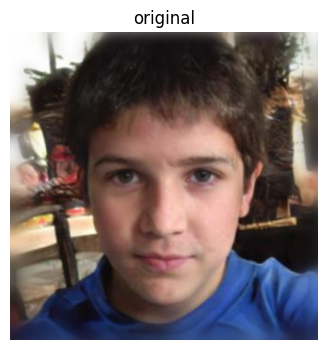

Optimizing Latents.
[2023-10-14 12:31:59,478][INFO] Loading pytorch model from `interfacegan/models/pretrain/stylegan_ffhq.pth`.
[2023-10-14 12:31:59,704][INFO] Successfully loaded!
[2023-10-14 12:31:59,704][INFO]   `lod` of the loaded model is 0.0.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 5

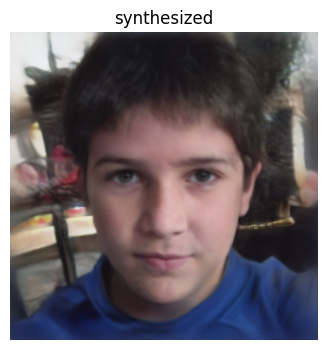

In [9]:
from PIL import Image
img = Image.open('MyImage.jpg')
show(np.array(img), sz=4, title='original')

!python encode_image.py ./MyImage.jpg\
    pred_dlatents_myImage.npy\
    --use_latent_finder true\
    --image_to_latent_path ./trained_models/image_to_latent.pt

pred_dlatents = np.load('pred_dlatents_myImage.npy')
pred_dlatent = torch.from_numpy(pred_dlatents).float().cuda()
pred_image = latent2image(pred_dlatent)
show(pred_image, sz=4, title='synthesized')

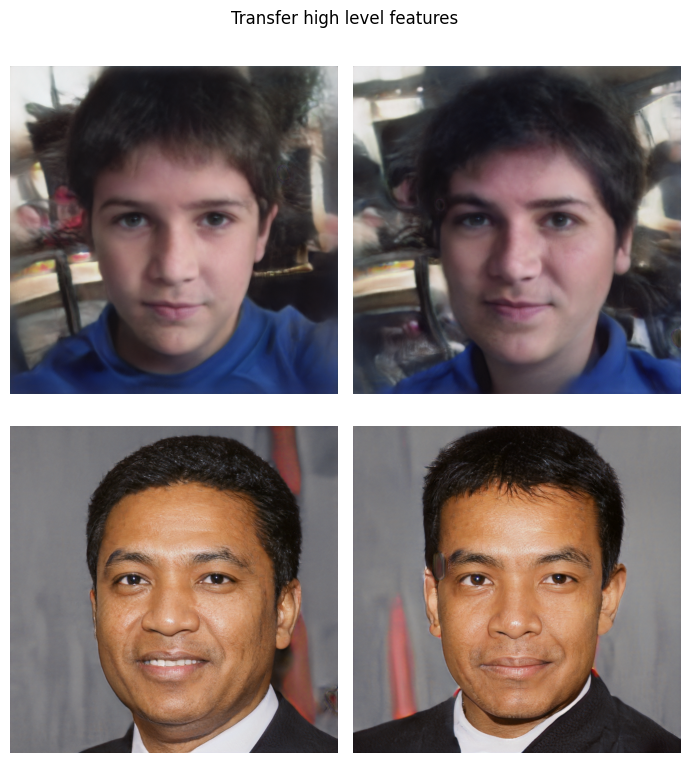

In [10]:
idxs_to_swap = slice(0,3)
my_latents = torch.Tensor(np.load('pred_dlatents_myImage.npy', allow_pickle=True))

A, B = latent2image(my_latents.cuda()), latent2image(trunc(mapper(rand_latents)))
generated_image_latents = trunc(mapper(rand_latents))

x = my_latents.clone()
x[:,idxs_to_swap] = generated_image_latents[:,idxs_to_swap]
a = latent2image(x.float().cuda())

x = generated_image_latents.clone()
x[:,idxs_to_swap] = my_latents[:,idxs_to_swap]
b = latent2image(x.float().cuda())

subplots([A,a,B,b], figsize=(7,8), nc=2, suptitle='Transfer high level features')

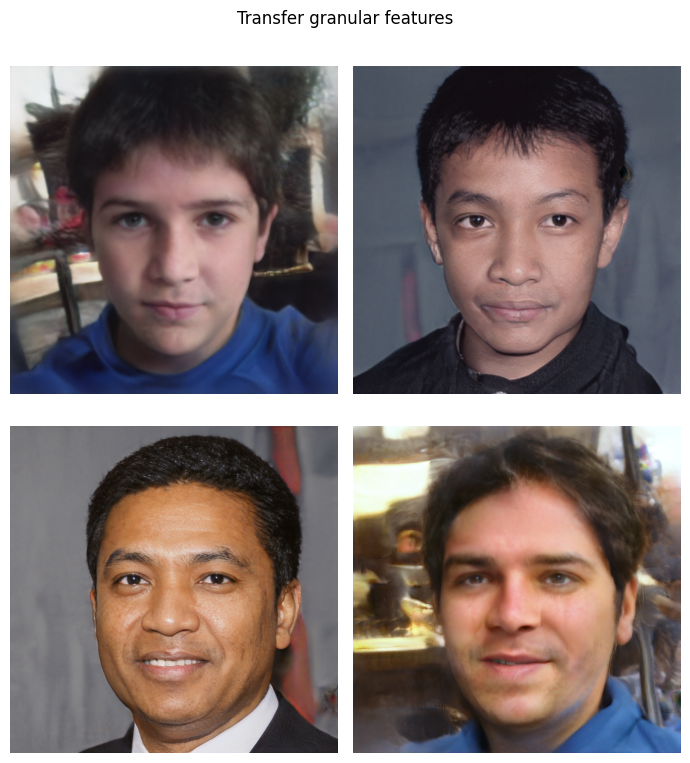

In [11]:
idxs_to_swap = slice(4,15)
my_latents = torch.Tensor(np.load('pred_dlatents_myImage.npy', allow_pickle=True))

A, B = latent2image(my_latents.cuda()), latent2image(trunc(mapper(rand_latents)))
generated_image_latents = trunc(mapper(rand_latents))

x = my_latents.clone()
x[:,idxs_to_swap] = generated_image_latents[:,idxs_to_swap]
a = latent2image(x.float().cuda())

x = generated_image_latents.clone()
x[:,idxs_to_swap] = my_latents[:,idxs_to_swap]
b = latent2image(x.float().cuda())

subplots([A,a,B,b], figsize=(7,8), nc=2, suptitle='Transfer granular features')

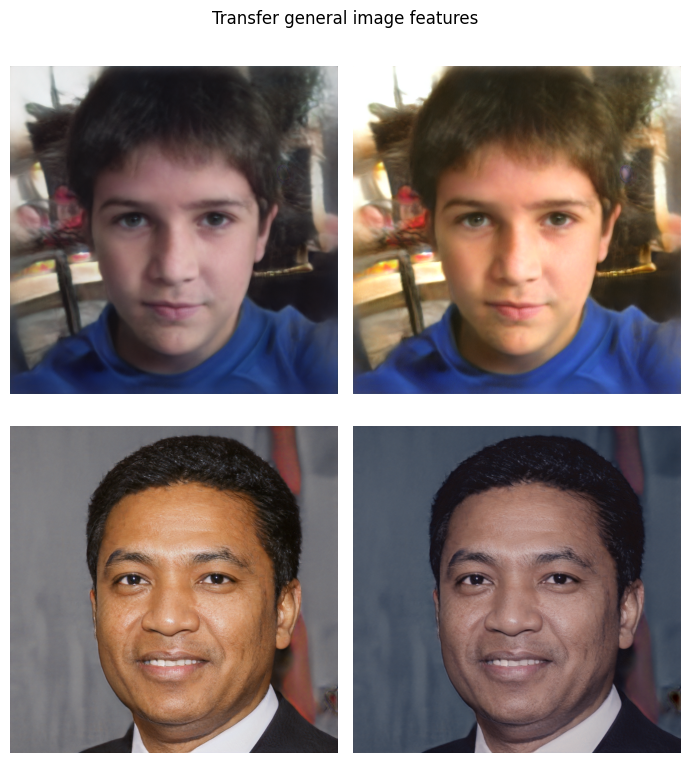

In [12]:
idxs_to_swap = slice(16,18)
my_latents = torch.Tensor(np.load('pred_dlatents_myImage.npy', allow_pickle=True))

A, B = latent2image(my_latents.cuda()), latent2image(trunc(mapper(rand_latents)))
generated_image_latents = trunc(mapper(rand_latents))

x = my_latents.clone()
x[:,idxs_to_swap] = generated_image_latents[:,idxs_to_swap]
a = latent2image(x.float().cuda())

x = generated_image_latents.clone()
x[:,idxs_to_swap] = my_latents[:,idxs_to_swap]
b = latent2image(x.float().cuda())

subplots([A,a,B,b], figsize=(7,8), nc=2, suptitle='Transfer general image features')

Work directory `results_new_smile` has already existed!
Please specify another one.


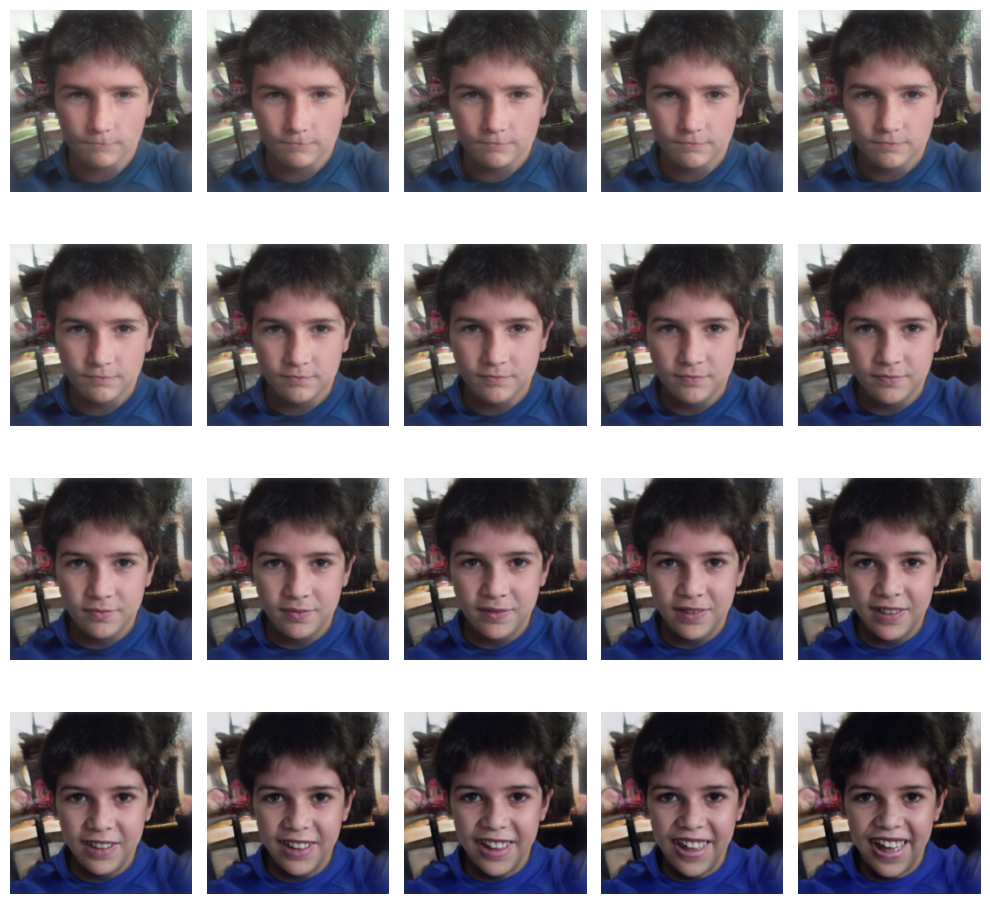

In [14]:
!python interfacegan/edit.py\
 -m stylegan_ffhq\
 -o results_new_smile\
 -b interfacegan/boundaries/stylegan_ffhq_smile_w_boundary.npy\
 -i pred_dlatents_myImage.npy\
 -s WP\
 --steps 20

generated_faces = Glob('results_new_smile/*.jpg')

subplots([read(im,1) for im in sorted(generated_faces)],figsize=(10,10))

---